(dl/04-lm)=
# Language Modeling

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/dl/04-lm.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings**: {cite}`d2l` https://github.com/karpathy/makemore 

## Introduction

TODO: Attribution fix

In this notebook, we introduce a **character-level** language model. This model can be used to generate new names using a Markov process after learning from a dataset of names. Our focus will be on introducing the overall framework of language modeling that includes probabilistic modeling and optimization.

## Names dataset

In [1]:
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats("svg")

Downloading the dataset:

In [2]:
!wget -O ./data/surnames_freq_ge_100.csv https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/fdce099ecb22d3b10da76448e1a7787048f12f26/surnames_freq_ge_100.csv
!wget -O ./data/surnames_freq_ge_20_le_99.csv https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/fdce099ecb22d3b10da76448e1a7787048f12f26/surnames_freq_ge_20_le_99.csv
col = ["surname", "frequency_first", "frequency_second", "frequency_both"]
df1 = pd.read_csv(DATASET_DIR / "surnames_freq_ge_100.csv", names=col, header=0)
df2 = pd.read_csv(DATASET_DIR / "surnames_freq_ge_20_le_99.csv", names=col, header=0)

--2024-02-29 06:00:52--  https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/fdce099ecb22d3b10da76448e1a7787048f12f26/surnames_freq_ge_100.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 485781 (474K) [text/plain]
Saving to: ‘./data/surnames_freq_ge_100.csv’

./data/surnames_fre 100%[===================>] 474.40K  --.-KB/s    in 0.1s    

2024-02-29 06:00:53 (3.46 MB/s) - ‘./data/surnames_freq_ge_100.csv’ saved [485781/485781]

--2024-02-29 06:00:53--  https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/fdce099ecb22d3b10da76448e1a7787048f12f26/surnames_freq_ge_20_le_99.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 848727 (829K) [text/plain]
Saving to: ‘./data/surnames_freq_ge_20_le_99.csv’

./data/surnames_fre 100%[===================>] 828.83K  1.05MB/s    in 0.8s    

2024-02-29 06:00:55 (1.05 MB/s) - ‘./data/surnames_freq_ge_20_le_99.csv’ saved [848727/848727]



In [3]:
df = pd.concat([df1, df2], axis=0)[['surname']].sample(frac=1.0)
df['surname'] = df['surname'].map(lambda s: s.lower())
df['surname'] = df['surname'].map(lambda s: s.replace("de la", "dela"))
df['surname'] = df['surname'].map(lambda s: s.replace(" ", "_"))

names = [n for n in df.surname.tolist() if "'" not in n and 'ç' not in n and len(n) >= 2]
df = df[['surname']].dropna().astype(str)
df = df[df.surname.isin(names)]
df.to_csv(DATASET_DIR / 'spanish_surnames.csv', index=False)
df = pd.read_csv(DATASET_DIR / 'spanish_surnames.csv').dropna()
df.head()

,surname
0,durana
1,dela_azuela
2,atlassi
3,irulegi
4,stockwell


All characters:

In [4]:
s = set(c for n in names for c in n)
chars = "".join(sorted(list(s)))
NUM_CHARS = len(chars)

print(chars)
print(NUM_CHARS)

_abcdefghijklmnopqrstuvwxyzñ
28


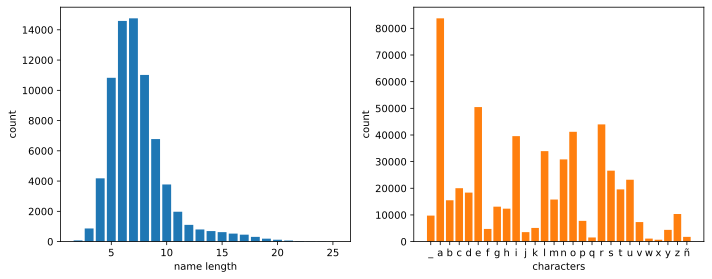

In [5]:
from collections import Counter

length_count = Counter([len(n) for n in names])
char_count = Counter("".join(names))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(length_count.keys(), length_count.values())
ax[0].set_xlabel("name length", fontsize=10)
ax[0].set_ylabel("count", fontsize=10)

keys = sorted(char_count.keys())
ax[1].set_ylabel("count")
ax[1].set_xlabel("characters")
ax[1].bar(keys, [char_count[k] for k in keys], color="C1")
fig.tight_layout()

Range of name lengths:

In [6]:
print("min:", min(length_count.keys()))
print("max:", max(length_count.keys()))
print("median:", int(np.median(sorted([len(n) for n in names]))))

min: 2
max: 25
median: 7


### Names as sequences

A name is technically a sequence of characters. The primary task of **language modeling** is to assign probabilities to sequences. Recall that we can write a joint distribution as a chain of conditional distributions:

$$
p(\boldsymbol{\mathsf x}_1, \ldots,\boldsymbol{\mathsf x}_n) = p(\boldsymbol{\mathsf x}_1) \prod_{t = 1}^{n-1} p(\boldsymbol{\mathsf x}_{t+1} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t}).
$$

In practice, we condition on a **context** consisting of previous characters $(\boldsymbol{\mathsf x}_{t-k+1}, \ldots, \boldsymbol{\mathsf x}_{t})$ of fixed size $k$ to approximate the conditional probability of $\boldsymbol{\mathsf x}_{t+1}.$ 
This is due to architectural constraints in our models. For example, we can create input-output pairs for the name `olivia` with context size 2: 

```
ol -> i
li -> v
iv -> a
``` 

These contexts are called **trigrams**. For context size 1, the pairs are called **bigrams**. In this notebook we will focus on bigrams, i.e. predicting the next character using a single character as context. And maybe look at how results improve by using a larger context.

**Padding.** Because our names are not infinite sequences, we have to model the start and end of names. We do this by introducing special characters for them and incorporating these into the dataset. For example:

```
[o -> l
li -> v
iv -> a
va -> ]
```

This way our models also learn how to start and end names. But observe that it suffices to use a single character `.` to indicate the start and end of a name. Sort of like a record button is pressed twice to record the characters.

```
.. -> o
ol -> i
li -> v
iv -> a
va -> .
```

Note that we use two dots (i.e. equal to the number of context) since we want the model to start from nothing to the first character.

### Dataloader

From the discussion above, we want to sample input-output pairs of each character and its context from names to model the conditional probabilities. This is implemented by the following class which builds all subsequences of characters $(\boldsymbol{\mathsf x}_{t-k+1}, \ldots,\boldsymbol{\mathsf x}_{t})$ of a name as input and the next character $\boldsymbol{\mathsf x}_{t+1}$ as the corresponding target to form our character-level dataset. 

For our purposes, the encoding simply maps characters to integers.

In [7]:
import torch
from torch.utils.data import Dataset

class CharDataset(Dataset):
    def __init__(self, contexts: list[str], targets: list[str], chars: str):
        self.chars = chars
        self.targets = targets
        self.contexts = contexts
        self.context_size = len(contexts[0])
        self.itos = {i: c for i, c in enumerate(self.chars)}
        self.stoi = {c: i for i, c in self.itos.items()}

    def get_vocab_size(self):
        return len(self.chars)
    
    def __len__(self):
        return len(self.contexts)
    
    def __getitem__(self, idx):
        x = self.encode(self.contexts[idx])
        y = torch.tensor(self.stoi[self.targets[idx]]).long()
        return x, y 
        
    def decode(self, x: torch.tensor) -> str:
        return "".join([self.itos[c.item()] for c in x])

    def encode(self, word: str) -> torch.tensor:
        return torch.tensor([self.stoi[c] for c in word]).long()


def build_dataset(names, context_size=3):
    """Build word context -> next char target lists from names."""
    xs = []     # context list
    ys = []     # target list
    for name in names:
        context = ["."] * context_size
        for c in name + ".":
            xs.append(context)
            ys.append(c)
            context = context[1:] + [c]
    
    chars = sorted(list(set("".join(ys))))
    return CharDataset(contexts=xs, targets=ys, chars=chars)

Using this we can create sequence datasets of arbitrary context size.

In [8]:
dataset = build_dataset(names, context_size=3)
xs = []
ys = []
for i in range(7):
    x, y = dataset[i]
    xs.append(x)
    ys.append(y)

pd.DataFrame({'x': [x.tolist() for x in xs], 'y': [y.item() for y in ys], 'x_word': ["".join(dataset.decode(x)) for x in xs], 'y_char': [dataset.itos[c.item()] for c in ys]})

,x,y,x_word,y_char
0,"[0, 0, 0]",5,...,d
1,"[0, 0, 5]",22,..d,u
2,"[0, 5, 22]",19,.du,r
3,"[5, 22, 19]",2,dur,a
4,"[22, 19, 2]",15,ura,n
5,"[19, 2, 15]",2,ran,a
6,"[2, 15, 2]",0,ana,.


## Counting *n*-grams

Bigrams can be thought of as input-output pairs with context size 1. An entry `[i, j]` in the array below is the count of bigrams that start with the `i`th character followed by the `j`th character. Recall that we use `.` to signify the start of a name which will be closed by another `.` to signify its end. Iterating over all names to get all existing bigrams:

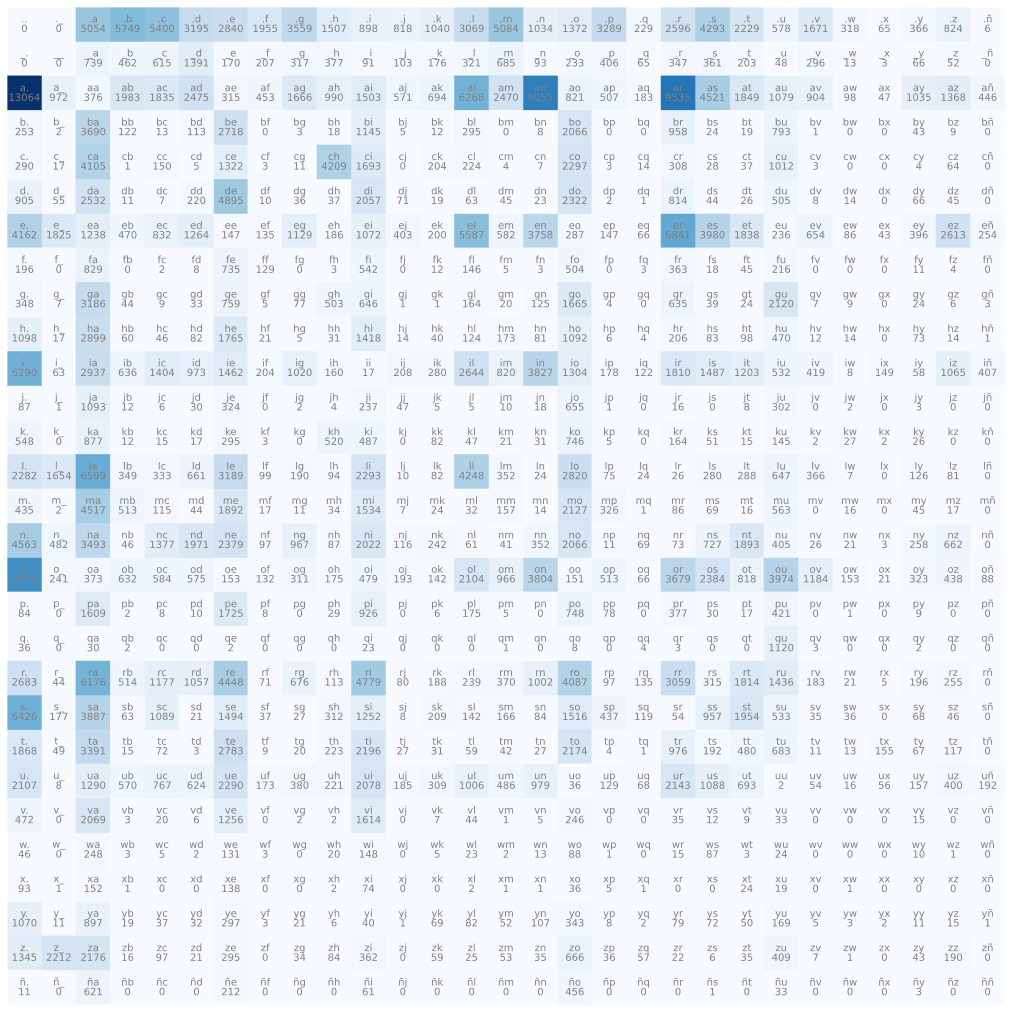

In [9]:
bigram_train = build_dataset(names[:int(0.80 * len(names))], context_size=1)
bigram_valid = build_dataset(names[int(0.80 * len(names)):], context_size=1)

# Create count matrix
n = bigram_train.get_vocab_size()
N2 = torch.zeros((n, n), dtype=torch.int32)
for x, y in bigram_train:
    N2[x[0].item(), y.item()] += 1

# Visualize count matrix
plt.figure(figsize=(18, 18))
plt.imshow(N2, cmap='Blues')
for i in range(N2.shape[0]):
    for j in range(N2.shape[1]):
        chstr = bigram_train.itos[i] + bigram_train.itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N2[i, j].item(), ha="center", va="top", color="gray")

plt.axis("off");

In [10]:
print(sum([int(n[0]  == "a") for n in names[:int(0.80 * len(names))]]))
print(sum([int(n[-1] == "a") for n in names[:int(0.80 * len(names))]]))

5054
13064


### Generating names

Already at this point we can generate names. Recall that we can write joint distributions as a chain of conditional probabilities. But that we condition only on limited context as a form of truncation or approximation. This process can also used as an algorithm to generate names. 

First, a character is sampled given the start context (i.e. `..` for trigrams). The context shifts by appending it with the last sampled character to sample a new one. For example, we adjust the context to `.e` after sampling `e` from `..`. This is repeated until we sample another `.` which indicates the end of a name.

In [11]:
def generate_names(P, dataset, sample_size, seed=2147483647):
    """Generate names from a Markov process with cond probability table P."""

    g = torch.Generator().manual_seed(seed)
    context_size = dataset.context_size
    names = []
    for _ in range(sample_size):
        out = []
        context = "." * context_size
        while True:
            x = dataset.encode(context)
            j = torch.multinomial(P[tuple(x)], num_samples=1, replacement=True, generator=g).item()
            if j == 0:
                break
            context = context[1:] + dataset.itos[j]
            out.append(dataset.itos[j])
        names.append("".join(out))
    return names

Generating names from conditional distributions estimated by counting bigrams:

In [12]:
P2 = N2 / (0.01 + N2.sum(dim=1, keepdim=True))
for name in generate_names(P2, bigram_train, sample_size=12, seed=0):
    print(name)

s
belaririmiña
s
er
halabarzamigereñeba
doitan_mbamco
peso
cunaifroci
adenabide
ge
ejasaceceicoo
bi


Trying out trigrams. Note smoothing for zero counts:

In [13]:
trigram_train = build_dataset(names[:int(0.80 * len(names))], context_size=2)
trigram_valid = build_dataset(names[int(0.80 * len(names)):], context_size=2)

# Create count matrix
n = trigram_train.get_vocab_size()
N3 = torch.zeros((n, n, n), dtype=torch.int32)
for x, y in trigram_train:
    N3[x[0].item(), x[1].item(), y.item()] += 1

P3 = N3 / (0.01 + N3.sum(dim=-1, keepdim=True))
for name in generate_names(P3, trigram_train, sample_size=12, seed=0):
    print(name)

sa
elarreiriña
sala
halabbazamigereñerne
diano_mez_coriescabon
eftocia
con
bidgkin
ejastenceirookhi
sansil
clano
motchailcaurbosahifedar


**Remark.** Names generated from bigrams look pretty bad, but still looks better than random. One straightforward way to improve this is to increase context size as we did above. This results in some qualitative improvement. But this solution does not scale to *n*-grams due to [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) where the next probable *n*-gram has a probability that drops exponentially from the last. Increasing the context size results in a longer tail.

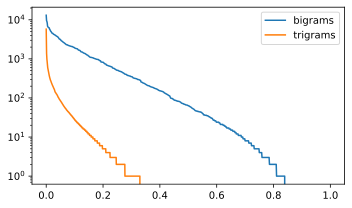

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(np.linspace(0, 1, N2.reshape(-1).shape[0]), sorted(N2.reshape(-1), reverse=True), label="bigrams")
ax.plot(np.linspace(0, 1, N3.reshape(-1).shape[0]), sorted(N3.reshape(-1), reverse=True), label="trigrams", color="C1")
ax.set_yscale("log")
ax.legend()
fig.tight_layout()

### Model quality: NLL

To measure model quality we use [maximum likelihood estimation](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/maximum-likelihood.html#the-maximum-likelihood-principle) (MLE). That is, we choose model parameters $\boldsymbol{\Theta}$ that maximizes the probability of the dataset. For our character-level language model, our objective will be to maximize the probability assigned by the model to the next character:

$$
\hat p(\boldsymbol{\mathsf{x}}_{t} \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1}; \boldsymbol{\Theta}).
$$

From the perspective of optimization, it is better to take the negative logarithm of the probability which is a positive function that increases rapidly as the probability goes to zero, and has a nonzero derivative even as the probability goes to 1. Hence, we take the resulting loss function called the **negative log-likelihood** which is equivalent to next-character MLE, but easier to optimize:

$$
\mathcal{L}(\boldsymbol{\Theta}) = \frac{1}{n} \sum_{\boldsymbol{\mathsf{x}}} \sum_t -\log\, \hat p(\boldsymbol{\mathsf{x}}_{t} \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1}; \boldsymbol{\Theta})
$$

where $n$ is the total number of characters to predict. Let us compute the NLL of the bigram model after fitting it on the counts. Note that bigram models assign probability using only the previous character, so that $\,\hat p(\boldsymbol{\mathsf{x}}_{t} \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1}; \boldsymbol{\Theta}) = f(\boldsymbol{\mathsf{x}}_{t-1}; \boldsymbol{\Theta}).$ 

### Modeling counts

Notice that we introduce a smoothing parameter $\alpha$. This is needed in case of zero counts, i.e. when contexts are not encountered in the training dataset, the model opts for a uniform distribution. As $\alpha \to \infty$, the output probabilities become more uniform for any input.

In [15]:
class CountingModel:
    def __init__(self, alpha=0.01):
        """Sequence model that uses observed n-grams to estimate next char proba."""
        self.P = None       # cond. prob
        self.N = None       # counts
        self.alpha = alpha  # smoothing zero counts

    def __call__(self, x: int) -> list[float]:
        return [torch.tensor(self.P[tuple(x)])]

    def fit(self, dataset: CharDataset):
        n = dataset.get_vocab_size()
        self.N = torch.zeros([n + 1] * (dataset.context_size + 1), dtype=torch.int32)
        for x, y in dataset:
            self.N[tuple(x)][y] += 1

        self.P = (self.N + self.alpha)/ (self.N.sum(dim=-1, keepdim=True)+ self.alpha)

Training the model on input and target sequences:

In [16]:
# Fitting the bigram model
bigram_model = CountingModel()
bigram_model.fit(bigram_train)

Computing the NLL of the bigram model:

In [17]:
@torch.inference_mode()
def evaluate_model(model, dataset):
    # Iterate over dataset one-by-one. Slow for large datasets.
    loss = 0.0
    n = 0
    for x, y in dataset:
        p = model(x)[0][y]
        loss += -torch.log(p)
        n += 1
        if n < 12:
            print(f"p({dataset.itos[y.item()]}|{dataset.itos[x[0].item()]})={p:.4f}    nll={-torch.log(p):.4f}")

    print("...")
    print(f"nll = {loss / n:.4f} (overall)")

evaluate_model(bigram_model, bigram_valid)

p(v|.)=0.0283    nll=3.5648
p(i|v)=0.2759    nll=1.2879
p(l|i)=0.0834    nll=2.4836
p(l|l)=0.1562    nll=1.8567
p(a|l)=0.2426    nll=1.4163
p(r|a)=0.1421    nll=1.9510
p(a|r)=0.1754    nll=1.7409
p(v|a)=0.0135    nll=4.3068
p(i|v)=0.2759    nll=1.2879
p(z|i)=0.0336    nll=3.3929
p(.|z)=0.1623    nll=1.8182
...
nll = 2.5036 (overall)


In [18]:
# Fitting the bigram model
trigram_model = CountingModel()
trigram_model.fit(trigram_train)
evaluate_model(trigram_model, trigram_valid)

p(v|.)=0.0283    nll=3.5648
p(i|.)=0.4668    nll=0.7619
p(l|v)=0.3389    nll=1.0820
p(l|i)=0.4728    nll=0.7491
p(a|l)=0.4007    nll=0.9146
p(r|l)=0.0908    nll=2.3994
p(a|a)=0.1163    nll=2.1515
p(v|r)=0.0215    nll=3.8380
p(i|a)=0.2622    nll=1.3387
p(z|v)=0.0260    nll=3.6486
p(.|i)=0.2751    nll=1.2905
...
nll = 2.3078 (overall)


**Remark.** A model that assigns a probability of `1.0` for each next actual character has a perfect NLL of exactly `0.0`. Here our count models get penalized for *n*-grams which occur rarely on the training dataset. Note that a random prediction is given by:

In [19]:
np.log(NUM_CHARS + 1)   # baseline

3.367295829986474

## Neural bigram model

To model bigrams, we consider a neural network with a single layer with a weight tensor $\boldsymbol{\mathsf W}$ of size `(28, 28)` that corresponds to the count matrix above. The relevant row of weights is picked out by computing $\boldsymbol{\mathsf w}_a = \boldsymbol{\mathsf x}_a \boldsymbol{\mathsf W}$ where $\boldsymbol{\mathsf x}_a$ is the one-hot encoding of the input character $a.$ Then, we apply softmax to $\boldsymbol{\mathsf w}_a$ which is a common technique for converting real-valued vectors to probabilities.

The model essentially is initialized with uniform conditional probabilities. The weights are then fine-tuned using SGD such that the probabilities of observed next characters are maximized (i.e. NLL is minimized). This model internally uses one-hot vectors to represent characters:

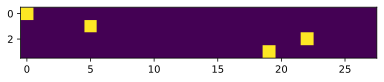

In [20]:
import torch.nn.functional as F
from torch.utils.data import DataLoader

bigram_dl = DataLoader(bigram_train, batch_size=4, shuffle=False)
x, y = next(iter(bigram_dl))
xenc = F.one_hot(x, num_classes=28).float() # convert to float
plt.imshow(xenc.view(4, -1)[:5, :]); # 0, 8, 2, 19

The model is implemented as follows:

In [21]:
class NNBigramModel:
    def __init__(self, alpha=0.01, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.W = torch.randn((NUM_CHARS + 1, NUM_CHARS + 1), generator=self.g, requires_grad=True)
        self.alpha = alpha

    def __call__(self, x):
        """Returns p(· | x) over characters."""
        xenc = F.one_hot(x, num_classes=NUM_CHARS + 1).float()
        logits = xenc.view(-1, NUM_CHARS + 1) @ self.W
        counts = logits.exp()
        probs = (counts + self.alpha) / (counts.sum(1, keepdim=True) + self.alpha)
        return probs
        
    def zero_grad(self):
        self.W.grad = None

Here weights with values in `(-inf, +inf)` can be interpreted as **log-counts** of bigrams that start on the row index. This is interesting because growth in the negative direction is different from growth in the positive direction. Applying `.exp()` we get units of count with values in `(0, +inf)`. These values are normalized to get an output vector with values in `(0, 1)` which we interpret as a probability distribution. Training the network will make these interpretations valid. 



```{figure} ../../img/bigram-nn.drawio.svg
---
width: 450px
name: bigram-nn.drawio
---

Schematic diagram of the bigram neural net. Computing the probability assigned by the model on `b` given `a` which is represented here as one-hot vector. Note that this is also the backward dependence for a bigram `ab` encountered during training with the NLL loss.
```

**Remark.** This is a pretty weak model (essentially learning a lookup table). A more complex model reflects a different prior regarding the character dependencies. For example, considering long range dependencies such that the generating names have lengths that follow the distribution of names in the dataset. 

### Model training

This should converge to a similar loss value as the bigram counting model (same capacity):

In [22]:
from tqdm.notebook import tqdm

model = NNBigramModel()
bigram_train_loader = DataLoader(bigram_train, batch_size=4096, shuffle=True)
bigram_valid_loader = DataLoader(bigram_valid, batch_size=4096, shuffle=True)

losses = []
num_steps = 1000
for k in tqdm(range(num_steps)):
    x, y = next(iter(bigram_train_loader))
    probs = model(x)
    loss = -probs[torch.arange(len(y)), y].log().mean()  # next char nll

    model.zero_grad()
    loss.backward()
    model.W.data -= 10.0 * model.W.grad
    
    # logging
    losses.append(loss.item())
    if k % int(0.10 * num_steps) == 0 or k == num_steps - 1:
        print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

[001/1000]   loss=3.7728
[101/1000]   loss=2.6045
[201/1000]   loss=2.5500
[301/1000]   loss=2.5515
[401/1000]   loss=2.5530
[501/1000]   loss=2.5352
[601/1000]   loss=2.5297
[701/1000]   loss=2.5271
[801/1000]   loss=2.5129
[901/1000]   loss=2.4955
[1000/1000]   loss=2.4752


In [23]:
evaluate_model(model, bigram_valid)

p(v|.)=0.0273    nll=3.6003
p(i|v)=0.2644    nll=1.3304
p(l|i)=0.0855    nll=2.4596
p(l|l)=0.1479    nll=1.9114
p(a|l)=0.2378    nll=1.4365
p(r|a)=0.1424    nll=1.9493
p(a|r)=0.1801    nll=1.7144
p(v|a)=0.0132    nll=4.3279
p(i|v)=0.2644    nll=1.3304
p(z|i)=0.0353    nll=3.3440
p(.|z)=0.1581    nll=1.8445
...
nll = 2.5098 (overall)


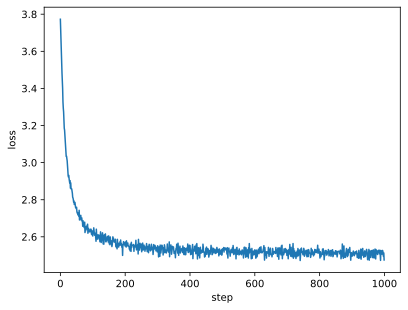

In [24]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('step');

### Sampling

Generating names and its associated NLL:

In [25]:
counts = model.W.exp()
P2_nn = (counts / counts.sum(dim=1, keepdim=True)).data

def name_loss(name, P, dataset):
    nll = 0.0
    context = "." * dataset.context_size
    for c in name + ".":
        p = P[dataset.encode(context), dataset.stoi[c]]
        nll += -math.log(p)
        context = context[1:] + c
    return nll / (len(name) + 1)


sample = generate_names(P2_nn, bigram_train, sample_size=12, seed=0)
name_losses = {n: name_loss(n, P2_nn, bigram_train) for n in sample}
for n in sorted(sample, key=lambda n: name_losses[n]):
    print(f"{n:<50} {name_losses[n]:.3f}")

s                                                  1.892
s                                                  1.892
peso                                               2.111
belaririmiña                                       2.194
adenabide                                          2.376
er                                                 2.460
halabarzamigereñeba                                2.573
ge                                                 2.574
sansibanlino                                       2.624
doitan_mbamco                                      2.748
cunaifroci                                         2.855
ejasaceceicoxabi                                   2.929


Recall that instead of maximizing names, we are maximizing next character likelihood. Hence, we can get names with low NLL (relative to the random baseline) even if these seem unlikely to occur naturally. Note that this is exactly the strength of generative models. Consequently, it should be rare that a generated name is in the training dataset:

In [26]:
print(r"Generated names found in train dataset:")
sample_size = 10000
print(f"{100 * sum([n in names for n in generate_names(P2_nn, bigram_train, sample_size=sample_size)]) / sample_size}% (sample_size={sample_size})")

Generated names found in train dataset:
16.25% (sample_size=10000)


From the conditional distributions, it looks like the neural net recovered the count matrix!

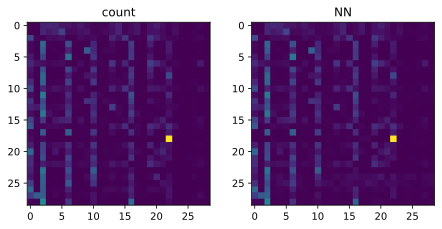

In [27]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout()

ax[0].imshow(P2)
ax[0].set_title("count")
ax[1].imshow(P2_nn)
ax[1].set_title("NN");

**Remark.** That one yellow dot is for "qu". :)

### Regularization

Observe that smoothing the count matrix approximates to it having constant entries. In the context of the neural net model, this means having a zero weight matrix so that the resulting count matrix `W.exp()` is a matrix of ones. The more getting zero weights is incentivized in the loss function, the more uniform the resulting distribution is. Another approach is **L2 regularization** or **weight decay** which adds ${\alpha}\lVert \boldsymbol{\mathsf W} \rVert^2_2$ to the loss function:

```python
loss += alpha * model.W.square().sum()
```

Notice that regularization acts like a force that pushes the weights to zero, whenever its magnitude increases to try to reduce the original NLL loss which depends on the training dataset. This also results in weights being smoothed out since the penalty grows quadratically in magnitude.

**Remarks.** This is called weight decay since the gradient of the L2 term subtracts to the weight. As such, weight decay should only be applied to weights (e.g. not to biases or embeddings), so that the base network expressivity is not affected.

## Character embeddings

---

■